# Imports and Drive mounting

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 12.6 MB/s 
     |████████████████████████████████| 1.8 MB 15.6 MB/s 
     |████████████████████████████████| 1.1 MB 78.6 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 72.0 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 352 kB 62.3 MB/s 
     |████████████████████████████████| 213 kB 74.7 MB/s 
     |████████████████████████████████| 1.2 MB 76.0 MB/s 
     |████████████████████████████████| 2.9 MB 14.8 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 895 kB 76.7 MB/s 
     |████████████████████████████████| 3.3 MB 53.3 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/NLP/proj finale/modules/utils.py" .
!cp "/content/drive/MyDrive/NLP/proj finale/modules/BERTmodels.py" .

import utils
from BERTmodels import * 

# Initializing 
In this section we initialize the dataset. The dataset split happens based on titles. 

The Dataset is stored as Json.
The overallo process consists in:
- json
- DataFrame
- Cleaning
- Tokenization
- Creation Input_Mask and Input_Ids
- Embedding through a BERT model
- Training the new model


In [ ]:
max_len = 512

# Save the slow pretrained tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

path = '/content/drive/MyDrive/NLP/proj finale/dataset'

df_orig = utils.create_df(path, [])
df = process_dataset(df_orig, tokenizer, answer_available=False, max_len=max_len)

In [ ]:
x_train,y_train, x_val, y_val = utils.train_test_split_on_title(df)

## BERT Ensemble Model
> The full explanation of the BERT Ensemble model is available on the attached report.

The ensemble model is composed by different neural networks. The following section shows the training of those networks with the same dataframe.


In the cell below we prepare:
 * The inputs for the neural netorks
 * TPU platform to accelerate the training
 * The accuracy function, loss, and optimizer
 * The callbacks for Earlystops and checkpoints

In [ ]:
# Create input layer for the neural networks
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

inputs = [input_ids, token_type_ids, attention_mask]

In [ ]:
save_path= '/content/drive/MyDrive/NLP/proj finale/saved_models/'

In [ ]:
# Create distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

ES_start = EarlyStopping(monitor='val_start_pred_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)
ES_end = EarlyStopping(monitor='val_end_pred_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)

def accuracy(y_true, y_pred):
    sampled = tf.argmax(y_pred, axis=-1)
    acc = 1 - tf.math.count_nonzero(tf.squeeze(tf.cast(y_true, tf.int64)) - sampled) / tf.cast(len(sampled), tf.int64)
    return acc

# Save the slow pretrained tokenizer
path = '/content/drive/MyDrive/NLP/proj finale/dataset'

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Average

In [ ]:
layer_option = "average"

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option)

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0
DEBUG:filelock:Attempting to acquire lock 140554987187216 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140554987187216 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140554987187216 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140554987187216 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_3[0][0]                

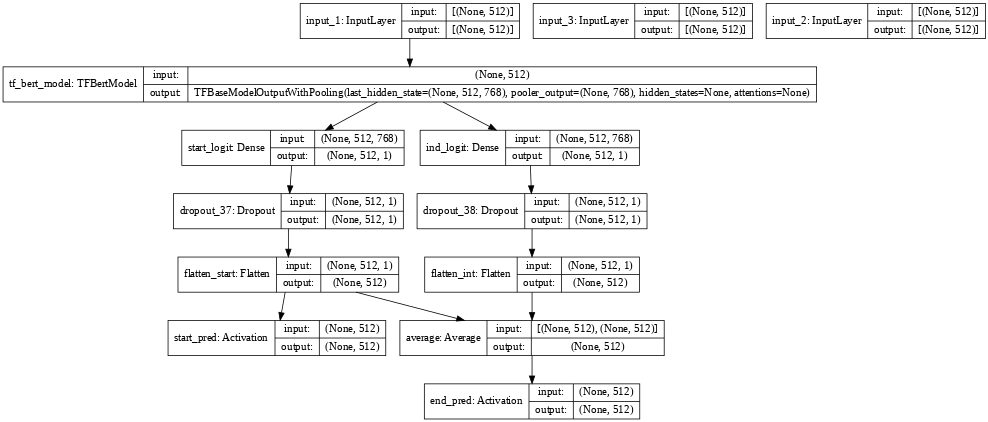

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - ETA: 0s - loss: 7.9875 - start_pred_loss: 4.2716 - end_pred_loss: 3.7159 - start_pred_accuracy: 0.2659 - end_pred_accuracy: 0.2799

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - 426s 664ms/step - loss: 7.9875 - start_pred_loss: 4.2716 - end_pred_loss: 3.7159 - start_pred_accuracy: 0.2659 - end_pred_accuracy: 0.2799 - val_loss: 3.5670 - val_start_pred_loss: 1.9560 - val_end_pred_loss: 1.6109 - val_start_pred_accuracy: 0.5761 - val_end_pred_accuracy: 0.6209

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_average.hdf5
Epoch 2/25
510/510 [==============================] - 259s 507ms/step - loss: 6.8211 - start_pred_loss: 3.7942 - end_pred_loss: 3.0269 - start_pred_accuracy: 0.3511 - end_pred_accuracy: 0.4193 - val_loss: 3.0675 - val_start_pred_loss: 1.6933 - val_end_pred_loss: 1.3742 - val_start_pred_accuracy: 0.6177 - val_end_pred_accuracy: 0.6617

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_average.hdf5
Epoch 3/25
510/510 [==============================] - 259s 508ms/step - loss: 6.5493 - start_pred_loss: 3.6971 - 

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_loss', 'end_pred_loss', 'start_pred_accuracy', 'end_pred_accuracy', 'val_loss', 'val_start_pred_loss', 'val_end_pred_loss', 'val_start_pred_accuracy', 'val_end_pred_accuracy'])

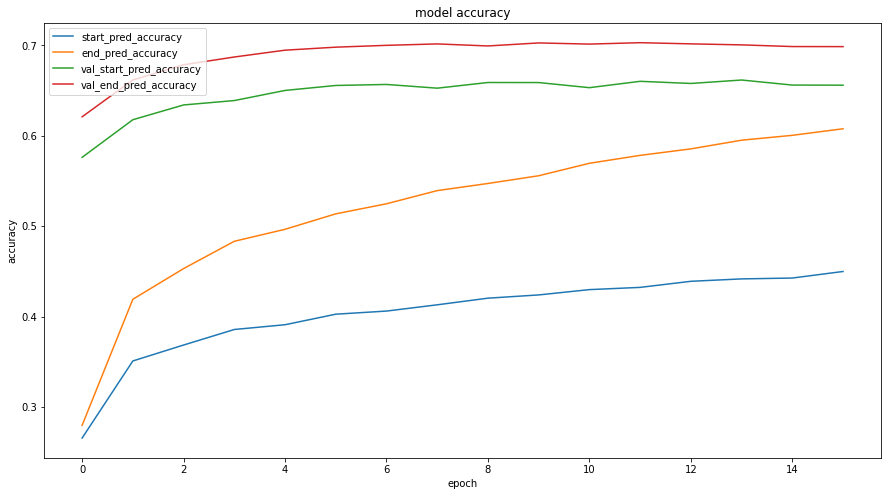

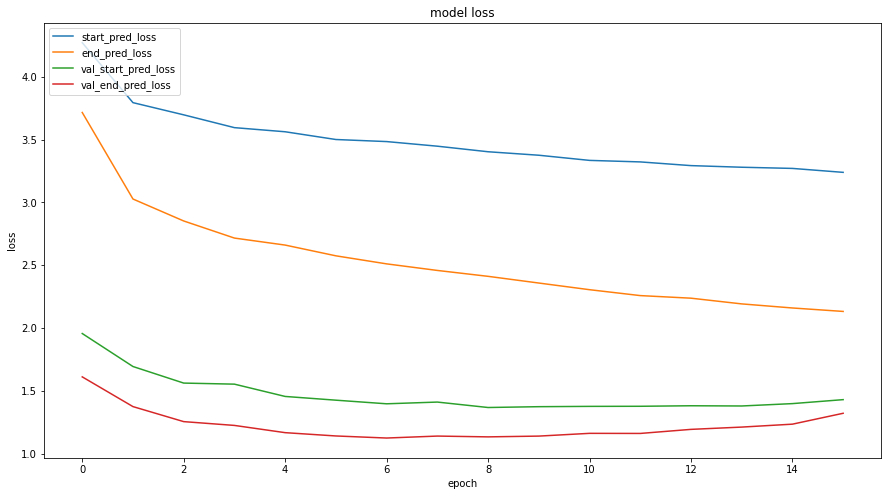

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_accuracy"])
plt.plot(history.history["end_pred_accuracy"])
plt.plot(history.history["val_start_pred_accuracy"])
plt.plot(history.history["val_end_pred_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_loss'])
plt.plot(history.history['end_pred_loss'])
plt.plot(history.history['val_start_pred_loss'])
plt.plot(history.history['val_end_pred_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# Maximum 

In [ ]:
layer_option = "maximum" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    # model = create_model_strano()
    model = create_bert_custom(model_name, custom_layer=layer_option)

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_4[0][0]                    
                                                                 input_6[0][0]              

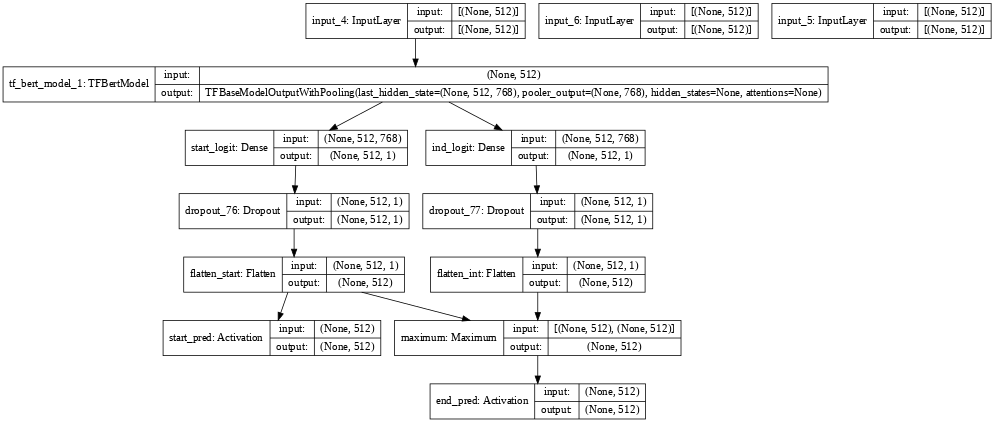

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)


In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - ETA: 0s - loss: 8.0804 - start_pred_loss: 4.4010 - end_pred_loss: 3.6794 - start_pred_accuracy: 0.2337 - end_pred_accuracy: 0.3243

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - 426s 662ms/step - loss: 8.0804 - start_pred_loss: 4.4010 - end_pred_loss: 3.6794 - start_pred_accuracy: 0.2337 - end_pred_accuracy: 0.3243 - val_loss: 4.3460 - val_start_pred_loss: 2.2616 - val_end_pred_loss: 2.0844 - val_start_pred_accuracy: 0.5190 - val_end_pred_accuracy: 0.6157

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_maximum.hdf5
Epoch 2/25
510/510 [==============================] - 259s 508ms/step - loss: 6.8893 - start_pred_loss: 3.9225 - end_pred_loss: 2.9668 - start_pred_accuracy: 0.3175 - end_pred_accuracy: 0.4562 - val_loss: 3.8048 - val_start_pred_loss: 2.0434 - val_end_pred_loss: 1.7614 - val_start_pred_accuracy: 0.5413 - val_end_pred_accuracy: 0.6612

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_maximum.hdf5
Epoch 3/25
510/510 [==============================] - 259s 508ms/step - loss: 6.6012 - start_pred_loss: 3.7868 - 

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_loss', 'end_pred_loss', 'start_pred_accuracy', 'end_pred_accuracy', 'val_loss', 'val_start_pred_loss', 'val_end_pred_loss', 'val_start_pred_accuracy', 'val_end_pred_accuracy'])

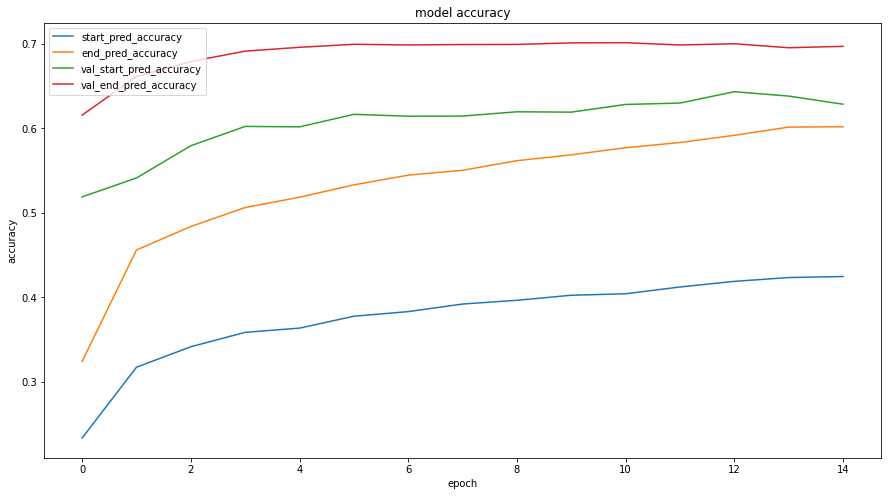

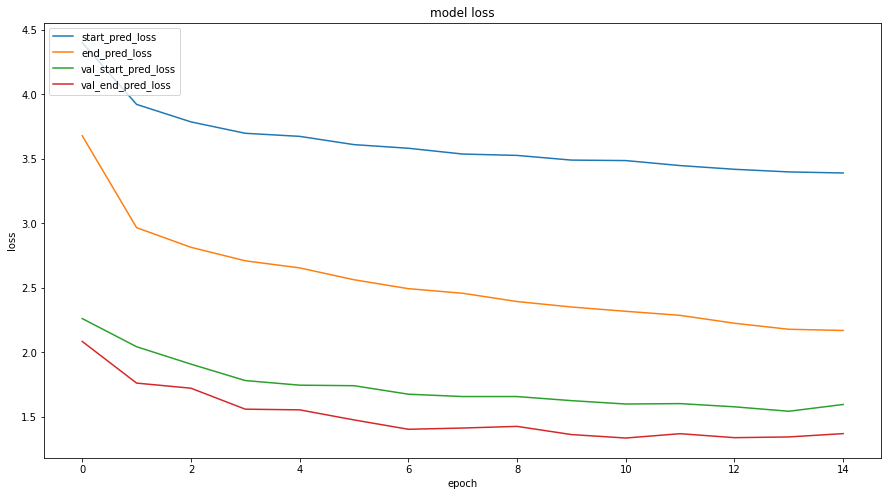

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_accuracy"])
plt.plot(history.history["end_pred_accuracy"])
plt.plot(history.history["val_start_pred_accuracy"])
plt.plot(history.history["val_end_pred_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_loss'])
plt.plot(history.history['end_pred_loss'])
plt.plot(history.history['val_start_pred_loss'])
plt.plot(history.history['val_end_pred_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# Add 

In [ ]:
layer_option = "add" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option)

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0
DEBUG:filelock:Attempting to acquire lock 140485525324752 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140485525324752 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140485525324752 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140485525324752 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_3[0][0]                

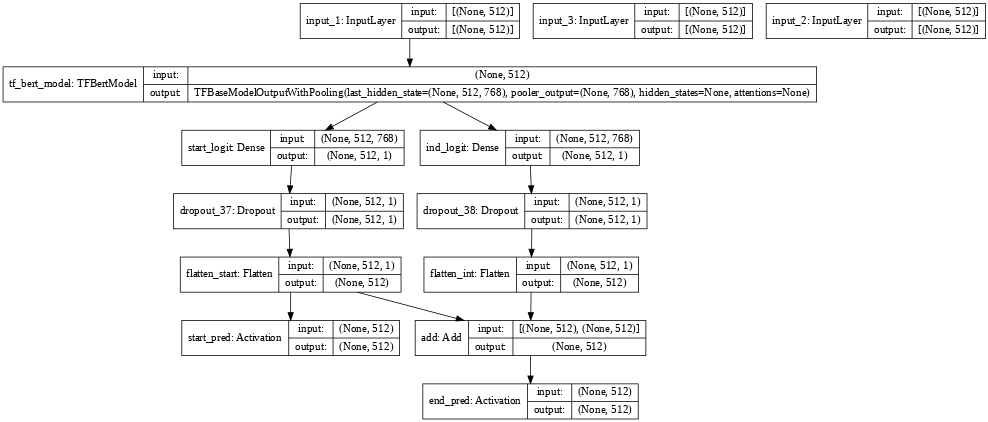

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - ETA: 0s - loss: 8.1355 - start_pred_loss: 4.3947 - end_pred_loss: 3.7408 - start_pred_accuracy: 0.2488 - end_pred_accuracy: 0.2745

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - 428s 666ms/step - loss: 8.1355 - start_pred_loss: 4.3947 - end_pred_loss: 3.7408 - start_pred_accuracy: 0.2488 - end_pred_accuracy: 0.2745 - val_loss: 3.9414 - val_start_pred_loss: 2.4064 - val_end_pred_loss: 1.5350 - val_start_pred_accuracy: 0.5500 - val_end_pred_accuracy: 0.6183

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_add.hdf5
Epoch 2/25
510/510 [==============================] - 261s 512ms/step - loss: 6.8667 - start_pred_loss: 3.8706 - end_pred_loss: 2.9961 - start_pred_accuracy: 0.3395 - end_pred_accuracy: 0.4185 - val_loss: 3.4225 - val_start_pred_loss: 2.0918 - val_end_pred_loss: 1.3307 - val_start_pred_accuracy: 0.5970 - val_end_pred_accuracy: 0.6593

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_add.hdf5
Epoch 3/25
510/510 [==============================] - 261s 511ms/step - loss: 6.5363 - start_pred_loss: 3.7420 - end_pred

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_loss', 'end_pred_loss', 'start_pred_accuracy', 'end_pred_accuracy', 'val_loss', 'val_start_pred_loss', 'val_end_pred_loss', 'val_start_pred_accuracy', 'val_end_pred_accuracy'])

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_accuracy"])
plt.plot(history.history["end_pred_accuracy"])
plt.plot(history.history["val_start_pred_accuracy"])
plt.plot(history.history["val_end_pred_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_loss'])
plt.plot(history.history['end_pred_loss'])
plt.plot(history.history['val_start_pred_loss'])
plt.plot(history.history['val_end_pred_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# Minimum 

In [ ]:
layer_option = "minimum" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]
# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option)

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0
DEBUG:filelock:Attempting to acquire lock 139819236766736 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 139819236766736 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139819236766736 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 139819236766736 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_3[0][0]                

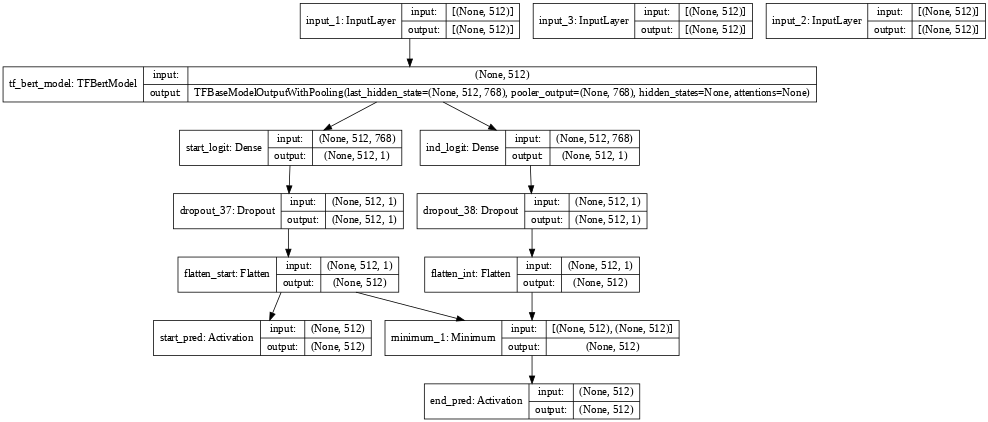

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)


In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - ETA: 0s - loss: 9.0451 - start_pred_loss: 4.3586 - end_pred_loss: 4.6865 - start_pred_accuracy: 0.2536 - end_pred_accuracy: 0.1485

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - 435s 669ms/step - loss: 9.0451 - start_pred_loss: 4.3586 - end_pred_loss: 4.6865 - start_pred_accuracy: 0.2536 - end_pred_accuracy: 0.1485 - val_loss: 4.2411 - val_start_pred_loss: 2.0994 - val_end_pred_loss: 2.1417 - val_start_pred_accuracy: 0.5718 - val_end_pred_accuracy: 0.5832

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_minimum.hdf5
Epoch 2/25
510/510 [==============================] - 262s 513ms/step - loss: 8.1084 - start_pred_loss: 3.8074 - end_pred_loss: 4.3010 - start_pred_accuracy: 0.3520 - end_pred_accuracy: 0.1988 - val_loss: 3.4898 - val_start_pred_loss: 1.7753 - val_end_pred_loss: 1.7144 - val_start_pred_accuracy: 0.6143 - val_end_pred_accuracy: 0.6334

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_minimum.hdf5
Epoch 3/25
510/510 [==============================] - 262s 514ms/step - loss: 7.8908 - start_pred_loss: 3.6839 - 

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_loss', 'end_pred_loss', 'start_pred_accuracy', 'end_pred_accuracy', 'val_loss', 'val_start_pred_loss', 'val_end_pred_loss', 'val_start_pred_accuracy', 'val_end_pred_accuracy'])

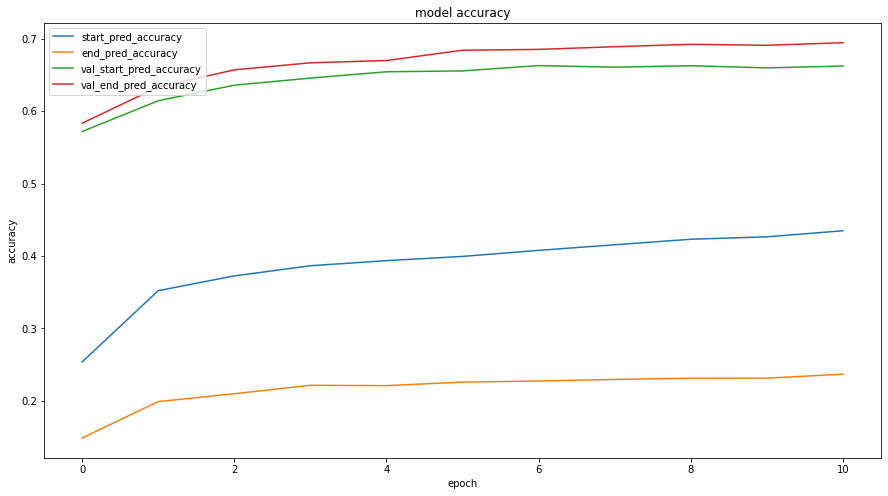

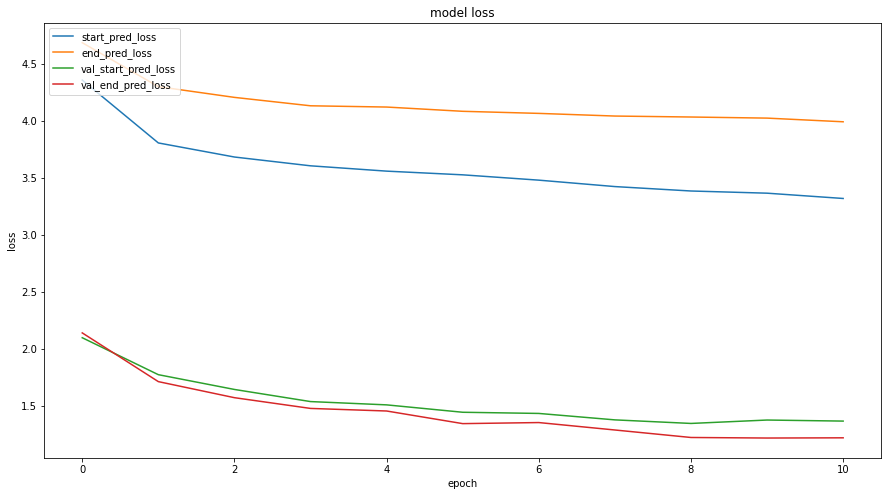

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_accuracy"])
plt.plot(history.history["end_pred_accuracy"])
plt.plot(history.history["val_start_pred_accuracy"])
plt.plot(history.history["val_end_pred_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_loss'])
plt.plot(history.history['end_pred_loss'])
plt.plot(history.history['val_start_pred_loss'])
plt.plot(history.history['val_end_pred_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# Subtract 

In [ ]:
layer_option = "subtract" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option)

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0
DEBUG:filelock:Attempting to acquire lock 140391683416016 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140391683416016 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140391683416016 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140391683416016 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_3[0][0]                

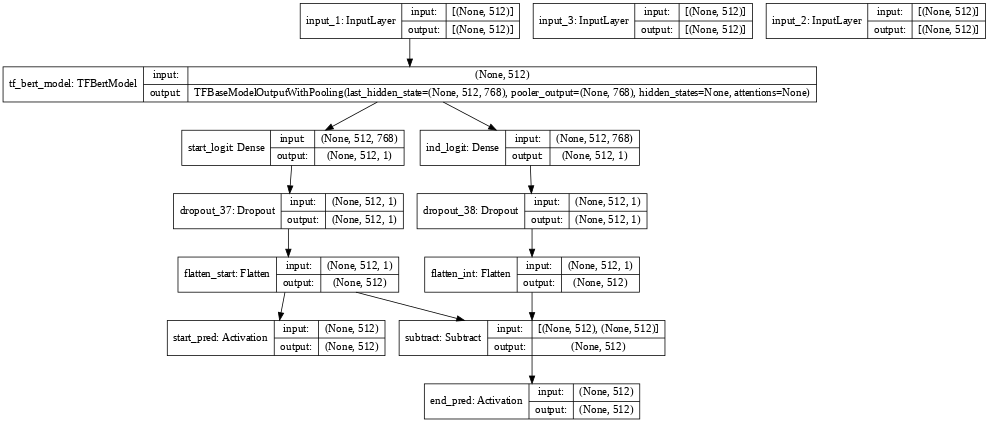

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)


In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - ETA: 0s - loss: 8.2760 - start_pred_loss: 4.4475 - end_pred_loss: 3.8284 - start_pred_accuracy: 0.2406 - end_pred_accuracy: 0.2616

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - 425s 663ms/step - loss: 8.2760 - start_pred_loss: 4.4475 - end_pred_loss: 3.8284 - start_pred_accuracy: 0.2406 - end_pred_accuracy: 0.2616 - val_loss: 4.0864 - val_start_pred_loss: 2.4947 - val_end_pred_loss: 1.5918 - val_start_pred_accuracy: 0.5524 - val_end_pred_accuracy: 0.6147

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_subtract.hdf5
Epoch 2/25
510/510 [==============================] - 259s 507ms/step - loss: 6.9230 - start_pred_loss: 3.8895 - end_pred_loss: 3.0335 - start_pred_accuracy: 0.3381 - end_pred_accuracy: 0.4102 - val_loss: 3.5141 - val_start_pred_loss: 2.1605 - val_end_pred_loss: 1.3536 - val_start_pred_accuracy: 0.5990 - val_end_pred_accuracy: 0.6598

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_subtract.hdf5
Epoch 3/25
510/510 [==============================] - 259s 508ms/step - loss: 6.5580 - start_pred_loss: 3.7514 

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_loss', 'end_pred_loss', 'start_pred_accuracy', 'end_pred_accuracy', 'val_loss', 'val_start_pred_loss', 'val_end_pred_loss', 'val_start_pred_accuracy', 'val_end_pred_accuracy'])

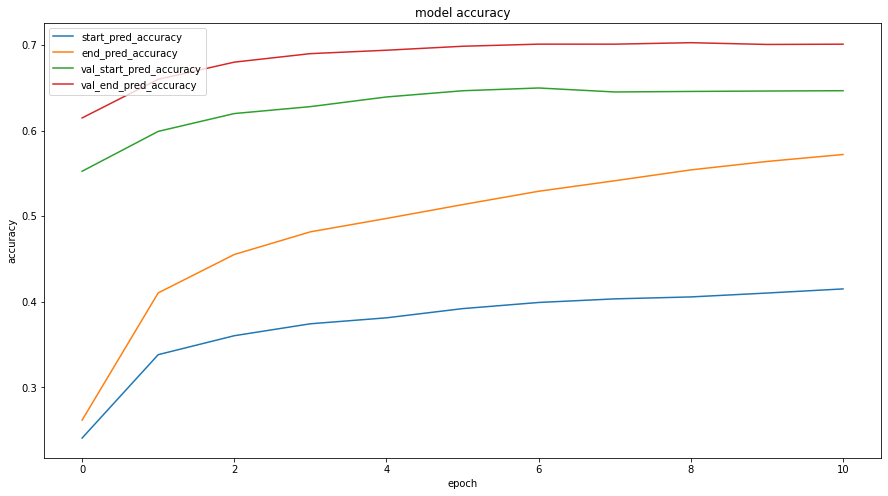

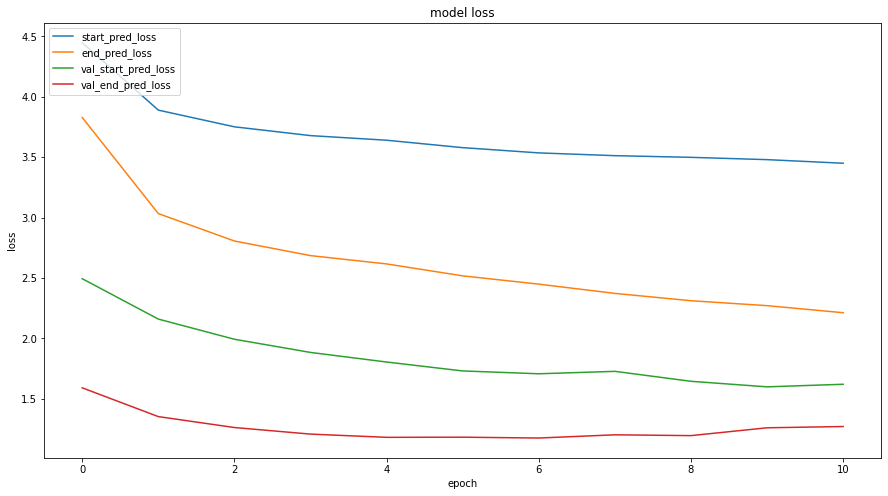

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_accuracy"])
plt.plot(history.history["end_pred_accuracy"])
plt.plot(history.history["val_start_pred_accuracy"])
plt.plot(history.history["val_end_pred_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_loss'])
plt.plot(history.history['end_pred_loss'])
plt.plot(history.history['val_start_pred_loss'])
plt.plot(history.history['val_end_pred_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# Multiply 

In [ ]:
layer_option = "multiply" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option)

model.summary()

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_4[0][0]                    
                                                                 input_6[0][0]              

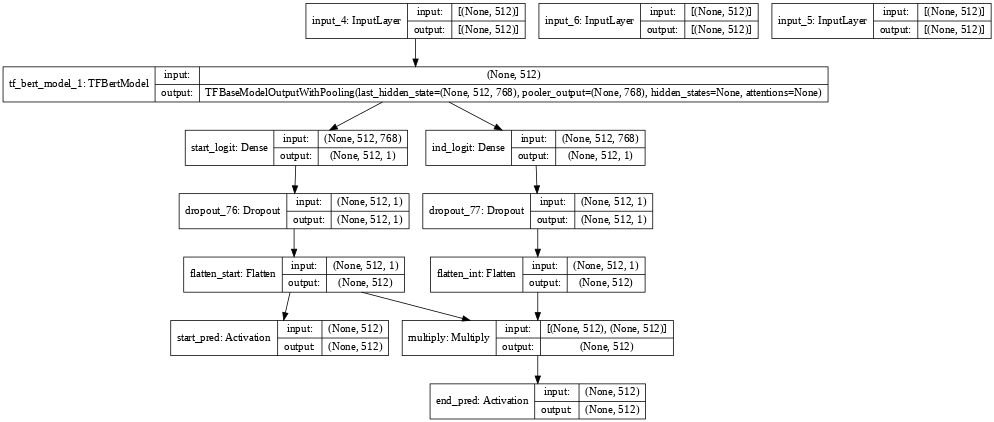

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - ETA: 0s - loss: 9.9853 - start_pred_loss: 4.4994 - end_pred_loss: 5.4860 - start_pred_accuracy: 0.2303 - end_pred_accuracy: 0.1311

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


510/510 [==============================] - 425s 661ms/step - loss: 9.9853 - start_pred_loss: 4.4994 - end_pred_loss: 5.4860 - start_pred_accuracy: 0.2303 - end_pred_accuracy: 0.1311 - val_loss: 5.7324 - val_start_pred_loss: 2.3812 - val_end_pred_loss: 3.3513 - val_start_pred_accuracy: 0.5618 - val_end_pred_accuracy: 0.5819

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_multiply.hdf5
Epoch 2/25
510/510 [==============================] - 259s 508ms/step - loss: 8.8309 - start_pred_loss: 3.8025 - end_pred_loss: 5.0285 - start_pred_accuracy: 0.3501 - end_pred_accuracy: 0.1959 - val_loss: 4.9214 - val_start_pred_loss: 2.0417 - val_end_pred_loss: 2.8797 - val_start_pred_accuracy: 0.6122 - val_end_pred_accuracy: 0.6347

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_multiply.hdf5
Epoch 3/25
510/510 [==============================] - 259s 508ms/step - loss: 8.6122 - start_pred_loss: 3.6625 

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_loss', 'end_pred_loss', 'start_pred_accuracy', 'end_pred_accuracy', 'val_loss', 'val_start_pred_loss', 'val_end_pred_loss', 'val_start_pred_accuracy', 'val_end_pred_accuracy'])

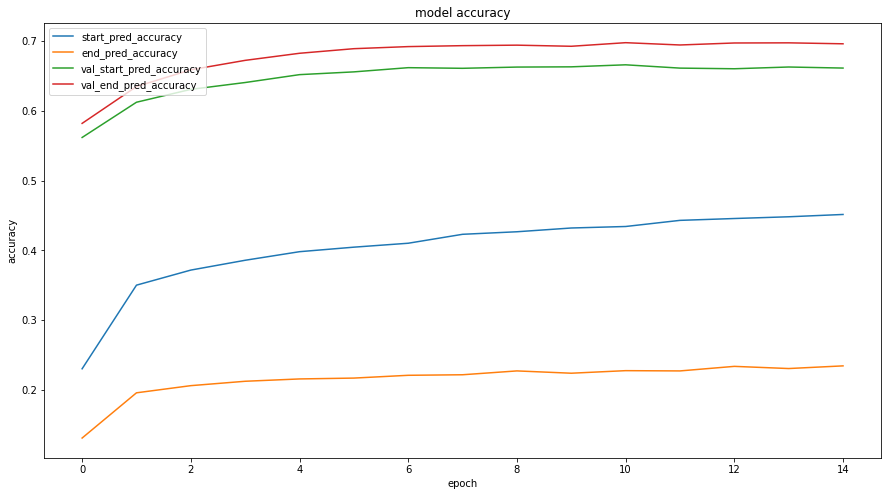

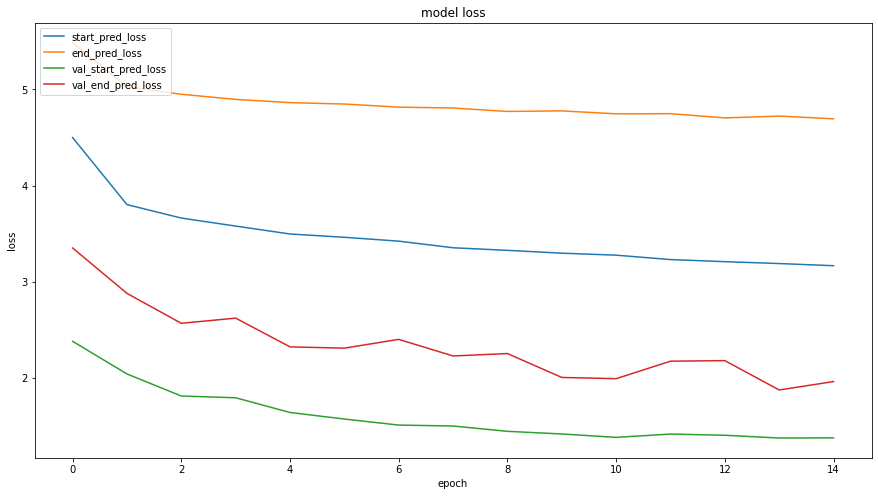

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_accuracy"])
plt.plot(history.history["end_pred_accuracy"])
plt.plot(history.history["val_start_pred_accuracy"])
plt.plot(history.history["val_end_pred_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_loss'])
plt.plot(history.history['end_pred_loss'])
plt.plot(history.history['val_start_pred_loss'])
plt.plot(history.history['val_end_pred_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()